# 基于链家二手房的Python爬虫与数据分析及可视化

##  1. 项目内容

**项目来源：本项目为Python课程结课作业**
 
**项目名称：基于链家二手房的Python爬虫与数据分析及可视化**

**基本内容：**

        ① 本项目为Python爬虫，包括在线数据解析、数据爬取、数据预处理、数据保存，读取本地数据、进行数据分析及可视化。

        ② 通过编写本程序，可以对课程所学内容有更深刻的理解，增加实战经验。

        ③ 通过数据分析及可视化，对数据信息有个全局的掌握和了解，便于做出决策。

##  2. 数据来源

**数据来源：数据基于链家网二手房的信息**

**数据长度：每个城市的链家网二手房页面，每页展示30条房屋信息，底部页数共有100页，因此最大长度为3000。**

**数据保存：爬虫分为爬取网页链接和房屋信息，因此共产生两个文件。**

        ① 一个为 城市前缀_links.xlsx 链接文件
        
        ② 一个为 城市前缀_results.xlsx 结果文件
        
        ③ 以上两个均为Excel文件（.xlsx）
        
**自带数据：本程序测试时已爬取了 北京 的二手房信息，在当前目录，文件名为 bj_links.xlsx、bj_results.xlsx。数据集长度为3000。**

**注意事项：**

 - **当指定城市为 北京 时，爬取过程会直接略过，显示文件已存在，可直接进行分析过程。**
 
 - **爬取新的城市时，如果出现类似于 pass data 的错误，主要原因是个别房屋的信息字段长度不一致，或多或少。可在oh_info 函数中修改。**
 
 - **爬取过程中可能会出现403情况，解决办法是增加 time.sleep() 时间。但会因此而增加总体爬取时间。**
 
 - **也许还有其他未知 Bug。**

##  3. 实现功能

**函数：本程序共 6 个函数**

    ① file_check ：检查文件是否存在，如果存在，返回True，否则返回False。

    ② get_proxy_ip ：获取代理ip，因爬取时间较长，采用代理ip来保证程序正常运行。返回ip列表。

    ③ op_title_link ：返回一页的二手房标题和链接。长度为30。返回格式为列表。

    ④ oh_info ：获取一套房子的所有信息。返回列表。长度为30。

    ⑤ t_file ：将数据写入DataFrame，并保存到Excel文件。

    ⑥ save ：爬取信息主函数。返回全部数据，用 t_file 函数将其保存。

**功能：**

    ① 指定城市
    ② 指定页数
    ③ 设置爬取速度
    ④ 在线获取代理IP
    ⑤ 在线爬取链家二手房信息
    ⑥ 实现交互图表——地图可视化（Echarts）
    ⑦ 分词，生成词云图
    ⑧ 普通图表 + 交互图表（Echarts）
    
##  4. 运行环境

**系统版本：Windows 10 x64 1809**

**Python：Python 3.7**

**IDE：Pycharm & Jupyter notebook**

**所用库：requests、re、BeautifulSoup、numpy、pandas、matplotlib、seaborn、jieba、wordcloud、imageio、time、os、random**

##  5. 关于

**姓名：左光明**

**学号：22017050615**

**专业：2017级 人口学**

**学院：劳动经济学院**

**邮箱：heykeener@163.com**

**程序开始**

In [1]:
# -*- coding: utf-8 -*- 
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import random
import jieba
import wordcloud
import imageio
# 导入以上所有库
# 记录开始时间
stime = time.time()
# 解决中文字符显示问题及负号显示错误
plt.rcParams['font.sans-serif'] = ["Simhei"]
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# base_url: 二手房信息首页，换做其他地区应该同样可行。比如上海（https://sh.lianjia.com/ershoufang/）。
# 设定地区，地区代码：北京->bj,上海->sh,天津->tj,重庆->cq,广州->gz,沈阳->sy,大连->dl ......
# 城市：北京
city = "bj"
base_url = "https://" + city + ".lianjia.com/ershoufang/"
# 设定页数。最大 100 页。默认为 5 页。
page_max = 5
pages = ["https://" + city + ".lianjia.com/ershoufang/pg"+str(i) for i in range(1, page_max + 1)]
# 间隔时间，单位：秒。此选项为随机生成一个 1 到 sec 秒的时间，缓解爬取速度。数值越大，爬取时间越长。
sec = 3
# pages

In [3]:
# 函数：检测文件是否存在，如果存在，返回True，否则返回False。参数为包含路径的文件名。
def file_check(filename):
    if os.path.exists(filename):
        return True
    else:
        return False


In [4]:
# 为了防止长时间爬取导致403，所以准备多个User-Agent和代理ip。但是还是有一定可能会被403。因此实际执行的时候间隔为随机1-3秒。
# User-Agent
header = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14",
    "Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.2; Win64; x64; Trident/6.0)",
    'Mozilla/5.0 (Windows; U; Windows NT 5.1; it; rv:1.8.1.11) Gecko/20071127 Firefox/2.0.0.11',
    'Opera/9.25 (Windows NT 5.1; U; en)',
    'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322; .NET CLR 2.0.50727)',
    'Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.5 (like Gecko) (Kubuntu)',
    'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.8.0.12) Gecko/20070731 Ubuntu/dapper-security Firefox/1.5.0.12',
    'Lynx/2.8.5rel.1 libwww-FM/2.14 SSL-MM/1.4.1 GNUTLS/1.2.9',
    "Mozilla/5.0 (X11; Linux i686) AppleWebKit/535.7 (KHTML, like Gecko) Ubuntu/11.04 Chromium/16.0.912.77 Chrome/16.0.912.77 Safari/535.7",
    "Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:10.0) Gecko/20100101 Firefox/10.0"
]


In [5]:
# 在线爬取代理IP。page为要爬取的页数。返回包含字典的列表。字典格式：{'HTTP': '101.231.50.154:8000'}，包括连接方式与IP和端口。
def get_proxy_ip(page):
    ipool = []
    for i in range(1, page+1):
        url = "http://ip.jiangxianli.com/?page=" + str(i)
        headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36"}
        html = requests.get(url,headers=headers)
        # html.text
        soup = BeautifulSoup(html.text, "html.parser")
        table = soup.findAll("table")
        ls = []
        # 解析 Table 表格
        for i in table[0].findAll("tr"):
            for j in i.findAll("td"):
                ls.append(j)
        # print(ls)
        ip = []
        port = []
        method = []
        for i in range(1, len(ls),10):
            ip.append(ls[i])
        for i in range(2, len(ls),10):
            port.append(ls[i])
        for i in range(4, len(ls),10):
            method.append(ls[i])
        
        for i in range(len(ip)):
            # 以字典形式写入列表
            ipool.append({"%s"%method[i].text:"%s"%ip[i].text+":"+port[i].text})
    return ipool


In [7]:
# 代理IP，来源于网络。
# 读取本地代理ip文件：proxy.txt。如果不存在则直接在线爬取代理IP并保存。
if file_check("./proxy.txt"):
    print("代理文件已存在，无需获取。")
    with open("./proxy.txt","r") as f:
        ip = f.read()
    f.close()
    proxy = eval(ip)
else:
    print("正在获取代理IP......")
    ipool = get_proxy_ip(5)
    with open("./proxy.txt","w") as f:
        f.write(str(ipool))
    f.close()
    print("代理IP爬取完毕。")
    with open("./proxy.txt","r") as f:
        ip = f.read()
    f.close()
    proxy = eval(ip)
# proxy

代理文件已存在，无需获取。


In [8]:
# 随机使用User-Agent和代理ip。每次随机从中选择一个。
headers = {"User-Agent": random.choice(header)}
proxys = {"User-Agent": random.choice(proxy)}


In [9]:
def op_title_link(base_url, proxys):
    """
    返回一页的二手房标题和链接。长度为30。每一页房屋数量为30个。
    :return: 返回列表
    """
    b_url = base_url
    tl_list = []
    d = requests.get(b_url, headers=headers, proxies=proxys)
    soup = BeautifulSoup(d.text, "html.parser")
    # 使用attrs属性是因为直接使用标签会多出非房屋信息，attrs比较精确
    title = soup.find_all(attrs={"class": "title", "data-el": "ershoufang"})
    for i in title:
        tl_list.append([i['href'], i.text])

    return tl_list


In [10]:
def oh_info(b_url, headers, proxys):
    """
    返回一套房子的所有信息，包括标题，价格信息，房屋基本信息，及交易信息等。
    :return: 列表。长度为30。
    """
    url = b_url
    i = requests.get(url, headers=headers, proxies=proxys)
    # 如果响应码为 200，说明正常返回信息。
    if i.status_code == 200:
        soup = BeautifulSoup(i.text, "html.parser")
        house_info_lst = []
        # 价格信息：总价，单价，单位
        house_title = soup.find_all("h1", "main")
        h_title = re.findall('<h1.*>(.*?)</h1>', str(house_title[0]))
        for i in h_title:
            house_info_lst.append(i)
        price = soup.find_all("div", "price")
        t_price = re.findall('<span class="total">(.*?)</span>', str(price[0]))
        t_price_unit = re.findall('<span class="unit"><span>(.*?)</span></span>', str(price[0]))
        unit_price = re.findall('<span class="unitPriceValue">(.*?)<i>(.*?)</i></span>', str(price[0]))
        house_price = [t_price, t_price_unit]
        # 小区信息，地址信息
        area_info = soup.find_all("div", "aroundInfo")
        # 小区名称
        community_name = re.findall('<span class="label">小区名称</span><a.*>(.*?)</a><a .*>地图</a>', str(area_info[0]))
        # 小区地址1，2，3，4
        area_address = re.findall('<span class="label">所在区域</span><span class="info"><a .*>(.*?)</a>.*<a .*>(.*?)</a>(.*?)</span><a .*>(.*?)</a>', str(area_info[0]))
        for i in community_name:
            house_info_lst.append(i)
        for i in area_address[0]:
            house_info_lst.append(i.strip())
        for i in house_price:
            for j in i:
                house_info_lst.append(j)
        for i in unit_price:
            for j in i:
                house_info_lst.append(j)
        # 有的城市会抓取到举报链接，因此将其处理为空
        house_info_lst[5] = "" if house_info_lst[5] == "举报" else house_info_lst[5]
        # print(house_info_lst)
        # 房屋信息
        house_info = soup.find_all("div", "introContent")
        base_info = re.findall('<li><span class="label">(.*?)</span>(.*?)</li>', str(house_info[0]))
        trans_info = re.findall(
            '<li>[\s]*<span class="label">(.*?)</span>[\s]*<span.*>[\s]*(.*?)[\s]*</span>[\s]*</li>',
            str(house_info[0]))
        base_info = dict(base_info)
        # 此处是为了处理pass data 错误，如果出现错误在这里修改，将其删除。
        base_info.pop("供暖方式", "tmperror")
        base_info.pop("用水类型", "tmperror")
        base_info.pop("用电类型", "tmperror")
        base_info.pop("燃气价格", "tmperror")
        for k, v in base_info.items():
            house_info_lst.append(v)
        for j in trans_info:
            house_info_lst.append(j[1])
        house_info_column_name = []
        for k, v in base_info.items():
            house_info_column_name.append(k)
        for j in trans_info:
            house_info_column_name.append(j[0])
        # 将 建筑面积 字段 的 ㎡ 替换为空，便于将其转换为数值格式，方便计算。
        house_info_lst[12] = house_info_lst[12].replace("㎡", "")

        for i in house_info_column_name:
            # 此处是为了处理pass data 错误，如果出现错误在这里修改，将其添加进列表。
            if i in ["供暖方式", "用水类型", "用电类型", "燃气价格"]:
                house_info_column_name.remove(i)
#         print(len(house_info_lst), house_info_lst) # 开启调试则取消注释，便于查看是哪一条记录出现错误，通常情况下，长度!=30，就会出现错误。
        # 返回房屋信息列表，字段列表
        return house_info_lst, house_info_column_name
    else:
        return False


In [11]:
# 用来写入DataFrame并保存到Excel文件。
def t_file(lsdd, filename, column):
    """
    用来写入DataFrame并保存到Excel文件。
    :param lsdd:所有房屋信息。
    :param filename:文件名。
    :param column:列名。
    :return:File。
    """
    df = pd.DataFrame(lsdd, columns=["标题", "小区名称", "地区", "地址1", "地址2", "地址3", "总价", "单位", "单价", "单位"]+column)
    # 将这三个字段转换为数值格式
    df[["总价", "单价", "建筑面积"]] = df[["总价", "单价", "建筑面积"]].apply(pd.to_numeric)
    df.to_excel(filename)
    print("\nFile " + filename + " Saved.")


In [12]:
# 爬取信息主函数。判断results.xlsx结果文件是否已经存在，如果存在则不执行，可直接进行分析。
# results.xlsx结果文件如果不存在，则检查links.xlsx链接文件是否存在，
# 如果存在则开始进行房屋信息爬取，如果不存在则先进行链接爬取并保存，再进行房屋信息爬取。
def save(filename,sec):
    """
    爬取信息主函数。判断results.xlsx文件是否已经存在，如果存在则不执行。
    :param filename: 文件名
    :param sec: 秒，执行间隔，随机1 - sec秒
    :return:
    """
    lsd = [] # 链接
    lsdd = [] # 房屋信息
    column = [] # 字段
    if file_check(filename):
        print("链接文件" + filename + "已存在，开始抓取房屋信息......")
        link = pd.read_excel(filename)
        for i in range(0, len(link)):
            lsd.append(link["链接"][i])
        print("Parsing House......")
        for j in range(0, len(lsd)):
            print("\rprocess : parsing house {0}/{1} ...".format(j + 1, len(lsd)), end="")
            res = oh_info(lsd[j], headers, proxys)
            lsdd.append(res[0])
            column.append(res[1])
            # 随机间隔
            time.sleep(random.randint(1,sec))
    else:
        print("链接文件" + filename + "不存在，开始抓取链接信息......")
        for i in range(0, len(pages)):
            print("\rprocess : parsing page {0}/{1}".format(i + 1, len(pages)), end="")
            lsd.extend(op_title_link(pages[i], proxys))
        dfl = pd.DataFrame(lsd, columns=["链接", "标题"])
        dfl.to_excel(filename)
        print("\nFile" + filename + " saved.")
        print("Parsing House......")
        for j in range(0, len(lsd)):
            print("\rprocess : parsing house {0}/{1} ...".format(j + 1, len(lsd)), end="")
            res = oh_info(lsd[j][0], headers, proxys)
            lsdd.append(res[0])
            column.append(res[1])
            # 随机间隔
            time.sleep(random.randint(1,sec))
    return lsdd, column


In [14]:
if file_check("./" + city + "_results.xlsx"):
    print("结果文件 " + city + "_results.xlsx" + " 已存在，无需下载，可直接使用此文件进行分析。")
else:
    filename = "./" + city + "_links.xlsx"
    lsdd = save(filename,sec)
#     print(lsdd)
#     for i in lsdd:
#         for j in i:
#             print(len(j), j)
    t_file(lsdd[0], "./" + city + "_results.xlsx", lsdd[1][0])

# 最多共100页，每页30个，总量3000个房屋。因使用代理，可能爬取时间较长。平均1-3秒一个，根据设定的sec确定。
# 记录结束时间
etime = time.time()
# 记录爬取用时。（notebook里面会从一开始就记录，持续到最后。因此时间不准确。）
print("time：" + str(etime - stime))

结果文件 bj_results.xlsx 已存在，无需下载，可直接使用此文件进行分析。
time：26.98258638381958


In [15]:
# 读入数据
origin_data = pd.read_excel("./" + city + "_results.xlsx")
# 标题为空，则房屋已下架
# 删除标题为空的行
data = origin_data.dropna(subset=["标题"])
# notebook里面使用print会有些错乱，因此直接打印表格。
data.head(5)


,标题,小区名称,地区,地址1,地址2,地址3,总价,单位,单价,单位.1,...,配备电梯,产权年限,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,抵押信息,房本备件
0,70年住宅 高楼层 正规两居室开发商精装 拎包入住,雅世合金公寓,海淀,田村,四至五环,NaN,820.0,万,90829,元/平米,...,有,70年,2018-12-11,商品房,2013-04-27,普通住宅,满五年,非共有,无抵押,已上传房本照片
1,北京西城月坛99年南北通透大两居，双阳台，采光无遮挡,月坛北街25号院,西城,月坛,二至三环,近9号线白堆子站,930.0,万,119692,元/平米,...,无,70年,2018-08-21,商品房,2013-09-09,普通住宅,满五年,非共有,无抵押,已上传房本照片
2,怡海花园四期一居 满五年唯一 楼层高 采光好,怡海花园富泽园,丰台,科技园区,三至四环,近9号线科怡路站,400.0,万,57054,元/平米,...,有,70年,2018-12-10,商品房,2008-04-22,普通住宅,满五年,非共有,有抵押 300万元 业主自还,已上传房本照片
3,新龙城不临街2居 只有契税 自住精装修 随时签约,新龙城,昌平,回龙观,五至六环,近13号线龙泽站,515.0,万,57001,元/平米,...,有,70年,2018-12-15,商品房,2009-04-17,普通住宅,满五年,共有,无抵押,已上传房本照片
4,房山 长阳全南向精致小巧两居 美好生活从现在开始,首开熙悦山澜庭,房山,长阳,五至六环,近房山线长阳站,313.0,万,44568,元/平米,...,有,70年,2018-12-16,商品房,2016-05-25,普通住宅,满两年,共有,无抵押,已上传房本照片


**通过他们的标题，一定程度上可以看出房屋的特点，来看看他们的标题都是怎么形容的……**

In [17]:
words = " ".join(data['标题'])
word = []
stopword = []
print("正在生成词云图......")
mask = imageio.imread("./mask.jpg")
# 加载停用表，过滤无意义文字或词。
with open("./stopword/停用表.txt","r") as f:
    sw = f.readlines()
for i in sw:
    # 去除特殊字符
    stopword.append(i.strip())
# print(stopword)
# 如果分词结果在停用表则略过。
for i in jieba.lcut(words):
    if i not in stopword:
        word.append(i)
wd = " ".join(word)
# 配置词云图，背景颜色、字体路径、蒙版等。如果要设置大小，可以加上：width=900,height=600,
wc = wordcloud.WordCloud(background_color="white",font_path="./font/msyh.ttf",mask=mask)
wc.generate(wd)
# 保存图片
wc.to_file("./word.jpg")
print("已保存。")

正在生成词云图......


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zgm\AppData\Local\Temp\jieba.cache
Loading model cost 1.992 seconds.
Prefix dict has been built succesfully.


已保存。


**显示词云图**
![](./word.jpg)

In [18]:
# 简单描述，只有这三个字段为数值格式，因此只显示这三个。
data.describe()

,总价,单价,建筑面积
count,2996.000000,2996.000000,2996.000000
mean,613.331776,62606.167557,97.227356
std,379.141789,21742.068060,38.903037
min,120.000000,17651.000000,26.420000
25%,380.000000,47449.000000,69.050000
50%,510.000000,58254.500000,90.100000
75%,700.000000,72863.250000,116.060000
max,4200.000000,149826.000000,485.860000


In [19]:
# 分组查看各地区的小区数量
# dis_count = pd.crosstab(data['地区'],data['小区名称'].count())
dis_count = data[['地区','小区名称']].groupby("地区").count()
# 倒序排列
dtc = dis_count.sort_values(by="小区名称",ascending=False)
dtc

,小区名称
地区,
朝阳,810
丰台,794
海淀,277
昌平,245
大兴,196
西城,160
房山,125
通州,92
东城,83


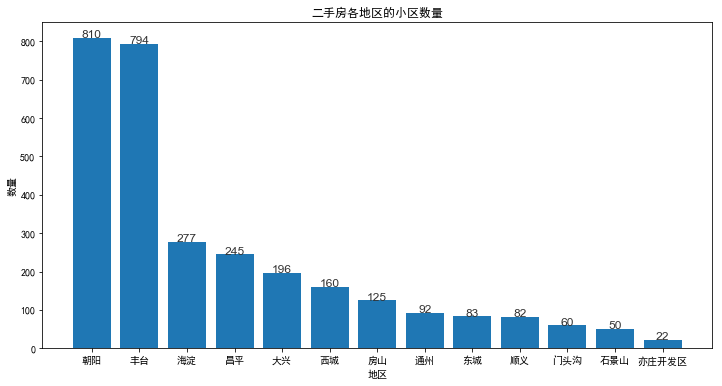

In [20]:
# 开始作图，可视化。
# 设置大小
plt.figure(figsize=(12, 6))
plt.bar(dtc.index,dtc["小区名称"])
plt.title("二手房各地区的小区数量")
plt.ylabel("数量")
plt.xlabel("地区")
# 增加数据标签
for x,y in zip(dtc.index,dtc["小区名称"]):
    plt.text(x,y+0.5,"%d"%y,fontdict={"family":"Arial","fontsize":12,"ha":"center","color":"#333333"})
plt.show()

**通过以上数据和图表发现，朝阳区和丰台区的二手房数量最多，均将近800个，占比超过50%。延庆、密云、怀柔、平谷则没有数据。**

**下面地图，使用Echarts库完成,需要联网加载，地图文件在当前目录下map目录。延庆、密云、怀柔、平谷没有数据，填充为0。亦庄开发区也没有在地图上显示。**

**本部分地图信息暂时不能随city变更而自动更换。数据需手动指定。**

In [21]:
# 本库为显示html内容。notebook自带。
from IPython.display import HTML
# html内容
htm = """
<div id='charts' style='width: 920px;height:600px;'></div>
<script>
    require.config({
        paths:{
            echarts:'//cdn.bootcss.com/echarts/4.1.0-release/echarts.min',
        }
    });
    require(['echarts'],function(ec){
        var myChart = ec.init(document.getElementById('charts'));
        $.get('./map/json/province/beijing.json', function (geoJson){
            ec.registerMap('北京',geoJson);
            var option = {
                title: {
                    text: '地区分布'
                },
                tooltip: {
                    trigger: 'item',
                    formatter: '{b}<br/>{c} 个房子'
                },
                toolbox: {
                    show: true,
                    orient: 'vertical',
                    left: 'right',
                    top: 'center',
                    feature: {
                        dataView: {readOnly: false},
                        restore: {},
                        saveAsImage: {}
                    }
                },
                visualMap: {
                    min: 0,
                    max: 1000,
                    text:['High','Low'],
                    realtime: false,
                    calculable: true,
                    inRange: {
                        color: ['lightskyblue','yellow', 'orangered']
                    }
                },
                series: [{
                    name: '北京',
                    type: 'map',
                    mapType:'北京',
                    roam: true,
                    itemStyle:{
                        normal:{label:{show:true}},
                        emphasis:{label:{show:true}}
                    },
                    data: [
                        {name: '朝阳区', value: 810},
                        {name: '丰台区', value: 794},
                        {name: '海淀区', value: 277},
                        {name: '昌平区', value: 245},
                        {name: '大兴区', value: 196},
                        {name: '西城区', value: 160},
                        {name: '房山区', value: 125},
                        {name: '通州区', value: 92},
                        {name: '东城区', value: 83},
                        {name: '顺义区', value: 82},
                        {name: '门头沟区', value: 60},
                        {name: '石景山区', value: 50},
                        {name: '亦庄开发区', value: 22},
                        {name: '延庆区', value: 0},
                        {name: '怀柔区', value: 0},
                        {name: '密云区', value: 0},
                        {name: '平谷区', value: 0},
                    ]
                }]
            };

            // 使用刚指定的配置项和数据显示图表。
            myChart.setOption(option);
        });
    });
</script>
"""
HTML(htm)

**通过地图可以发现，二手房集中朝阳区和丰台区，两个区占比超过50%。**

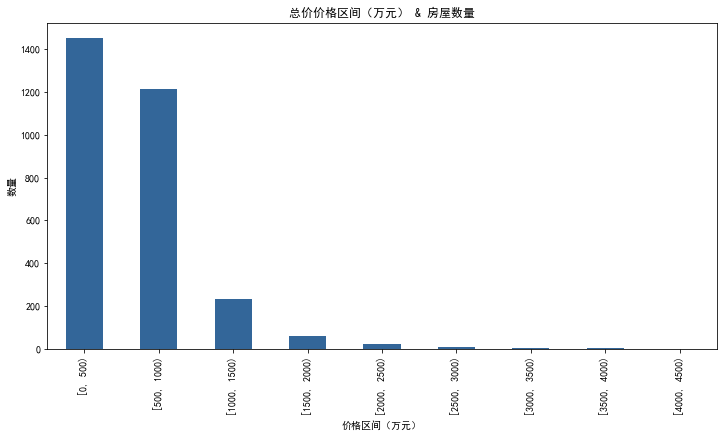

In [22]:
# data['总价'].sort_values()
# 对价格进行分组
price_cat = pd.cut(data['总价'].values,[0,500,1000,1500,2000,2500,3000,3500,4000,4500],right=False)
# 每一组的数量
price_cate = price_cat.value_counts()
plt.figure(figsize=(12, 6))
# 柱状图
price_cate.plot(kind="bar",color="#336699")
plt.title("总价价格区间（万元） & 房屋数量")
plt.xlabel("价格区间（万元）")
plt.ylabel("数量")
plt.show()

**通过图表可以看出，价格在500万元以下的房子超过1400套，500-1000万元的房子1200套左右，1000-1500万元的房子达到200套以上。1000万元以下聚集了大部分的房屋。**

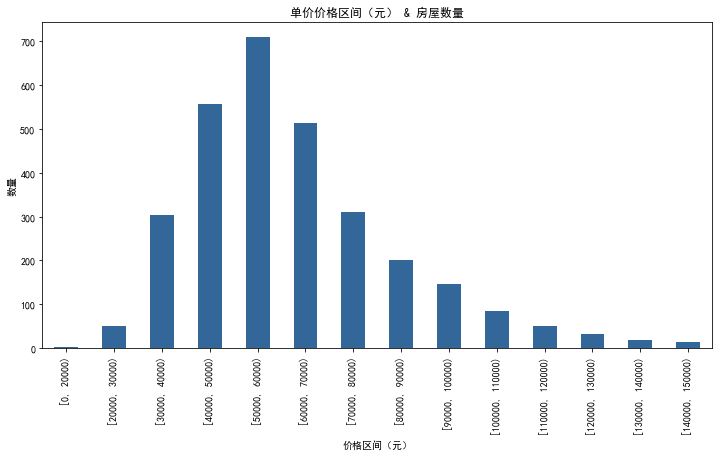

In [23]:
# print(data['单价'].sort_values())
# 对价格进行分组
price_cat_u = pd.cut(data['单价'].values,[0,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000],right=False)
# 每一组的数量
price_cate_u = price_cat_u.value_counts()
plt.figure(figsize=(12, 6))
# 柱状图
price_cate_u.plot(kind="bar",color="#336699")
plt.title("单价价格区间（元） & 房屋数量")
plt.xlabel("价格区间（元）")
plt.ylabel("数量")
plt.show()

**在单价方面，50000-60000元/平米的房子最多，其次是40000-50000元/平米，再其次是60000-70000元/平米，这三部分占到一半以上；低于20000元/平米的数量非常少。**

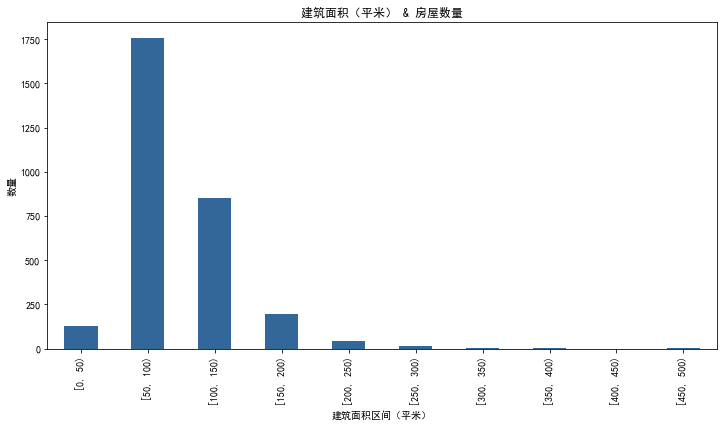

In [24]:
# print(data['建筑面积（平米）'].sort_values())
# 倒序排列
area_cat = pd.cut(data['建筑面积'].values,[i for i in range(0,550,50)],right=False)
# 每一组的数量
area_cate = area_cat.value_counts()
plt.figure(figsize=(12, 6))
area_cate.plot(kind="bar",color="#336699")
plt.title("建筑面积（平米） & 房屋数量")
plt.xlabel("建筑面积区间（平米）")
plt.ylabel("数量")
plt.show()

**在建筑面积方面，最多的是50-100平米的房子，达到1750左右，占到50%以上，其次是100-150平米的房子。**

In [25]:
# 填充缺失值
data['地址2'].fillna("暂无数据", inplace=True)
# print(data['地址2'].head())
data_cir = data[['地址2', '小区名称']].groupby("地址2").count()
data_cir = data_cir.sort_values(by="小区名称",ascending=False)
print(data_cir)

      小区名称
地址2       
五至六环   909
三至四环   768
四至五环   666
二至三环   378
六环外    171
二环内     83
暂无数据    21


c:\users\zgm\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


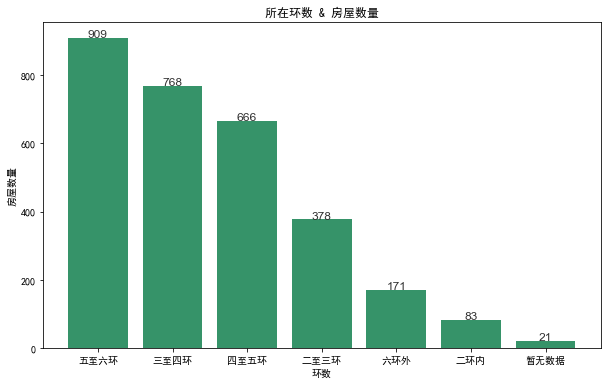

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(data_cir.index,data_cir['小区名称'],color="#369369")
plt.title("所在环数 & 房屋数量")
plt.xlabel("环数")
plt.ylabel("房屋数量")
for x,y in zip(data_cir.index,data_cir['小区名称']):
    plt.text(x,y+0.5,"%d"%y,fontdict={"family":"Arial","fontsize":12,"ha":"center","color":"#333333"})
plt.show()

**同样可以发现，五六环的房子最多，其次是三四环，然后是四五环，还有21个没有数据。**

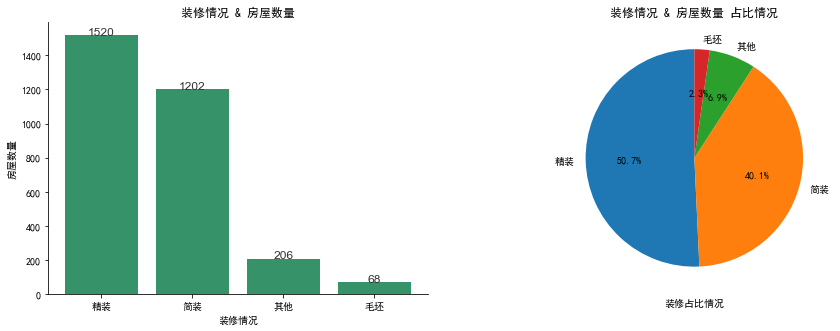

In [27]:
fig = plt.figure(figsize=(15, 5))
# 多图显示
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# 分组统计
data_modif = data[['装修情况','小区名称']].groupby('装修情况').count()
# 排序
data_modif = data_modif.sort_values(by="小区名称",ascending=False)
ax1.bar(data_modif.index,data_modif['小区名称'],color="#369369")
ax1.set_title("装修情况 & 房屋数量")
ax1.set_xlabel("装修情况")
ax1.set_ylabel("房屋数量")
# 设置边框显示
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# 数据标签
for x,y in zip(data_modif.index,data_modif['小区名称']):
    ax1.text(x,y+0.5,"%d"%y,fontdict={"family":"Arial","fontsize":12,"ha":"center","color":"#333333"})
labels = data_modif.index
sizes = data_modif['小区名称']
# 饼图
ax2.pie(sizes,labels=labels,labeldistance = 1.1,autopct = '%3.1f%%',shadow = False,startangle = 90,pctdistance = 0.6)
ax2.set_title("装修情况 & 房屋数量 占比情况")
ax2.set_xlabel("装修占比情况")
plt.show()

**装修情况：精装修占比50.7%，简装占比40.1%，毛坯占2.3%，其余为其他类型。**

**其他城市未保存供暖方式选项，因此本部分只在程序自带的数据集适用。如果重新爬取则无此选项，跳过即可。**

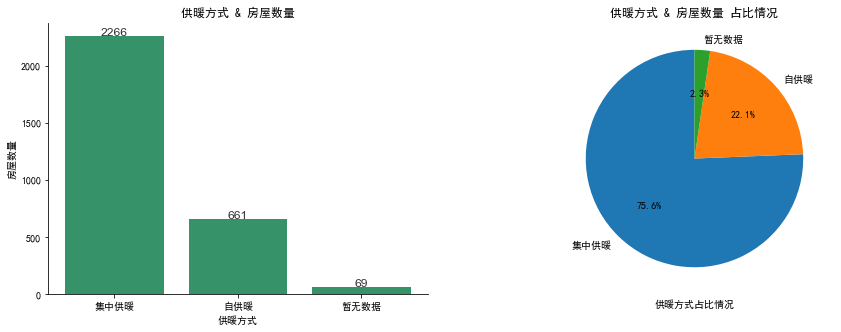

In [28]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
data_warm = data[['供暖方式','小区名称']].groupby('供暖方式').count()
data_warm = data_warm.sort_values(by="小区名称",ascending=False)
ax1.bar(data_warm.index,data_warm['小区名称'],color="#369369")
ax1.set_title("供暖方式 & 房屋数量")
ax1.set_xlabel("供暖方式")
ax1.set_ylabel("房屋数量")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for x,y in zip(data_warm.index,data_warm['小区名称']):
    ax1.text(x,y+0.5,"%d"%y,fontdict={"family":"Arial","fontsize":12,"ha":"center","color":"#333333"})
labels = data_warm.index
sizes = data_warm['小区名称']
ax2.pie(sizes,labels=labels,labeldistance = 1.1,autopct = '%3.1f%%',shadow = False,startangle = 90,pctdistance = 0.6)
ax2.set_title("供暖方式 & 房屋数量 占比情况")
ax2.set_xlabel("供暖方式占比情况")
plt.show()

**供暖方式方面，集中供暖占据75%以上，自供暖占22.1%。说明供暖还是以集中供暖为主。**

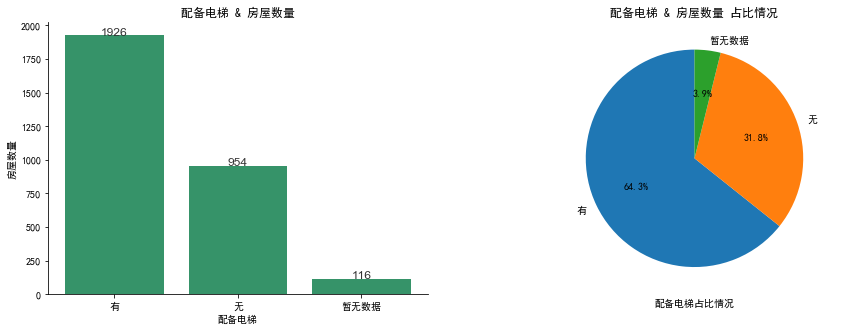

In [29]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
data_elevator = data[['配备电梯','小区名称']].groupby('配备电梯').count()
data_elevator = data_elevator.sort_values(by="小区名称",ascending=False)
ax1.bar(data_elevator.index,data_elevator['小区名称'],color="#369369")
ax1.set_title("配备电梯 & 房屋数量")
ax1.set_xlabel("配备电梯")
ax1.set_ylabel("房屋数量")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for x,y in zip(data_elevator.index,data_elevator['小区名称']):
    ax1.text(x,y+0.5,"%d"%y,fontdict={"family":"Arial","fontsize":12,"ha":"center","color":"#333333"})
labels = data_elevator.index
sizes = data_elevator['小区名称']
ax2.pie(sizes,labels=labels,labeldistance = 1.1,autopct = '%3.1f%%',shadow = False,startangle = 90,pctdistance = 0.6)
ax2.set_title("配备电梯 & 房屋数量 占比情况")
ax2.set_xlabel("配备电梯占比情况")
plt.show()

**有电梯的房子占64.3%，没有电梯的房子值31.8%。**

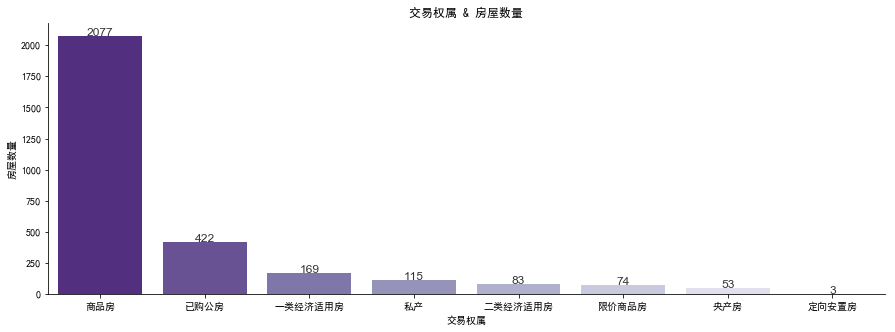

In [30]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
data_trans = data[['交易权属','小区名称']].groupby('交易权属').count()
data_trans = data_trans.sort_values(by="小区名称",ascending=False)
ax1.bar(data_trans.index,data_trans['小区名称'],color="#369369")
# seaborn 库画图
sns.barplot(data_trans.index,data_trans['小区名称'],palette="Purples_r")
ax1.set_title("交易权属 & 房屋数量")
ax1.set_xlabel("交易权属")
ax1.set_ylabel("房屋数量")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for x,y in zip(data_trans.index,data_trans['小区名称']):
    ax1.text(x,y+0.5,"%d"%y,fontdict={"family":"Arial","fontsize":12,"ha":"center","color":"#333333"})
plt.show()

**商品房占大多数，达到2000以上。其他还有经济适用房等等多种类型。**

In [31]:
data['挂牌时间'].apply(pd.to_datetime)
data['挂牌时间'].sort_values(ascending=True)
data_day_num = data[['挂牌时间','小区名称']].groupby('挂牌时间').count()
data_col_1 = data_day_num['小区名称']
data_col_2 = data_day_num.index
# 拼接字符串，将数据填充进去，使用Echarts前端库显示交互图表。
html = """
<div id='chartss' style='width: 800px;height:400px;'></div>
<script>
    require.config({
        paths:{
            echarts:'//cdn.bootcss.com/echarts/4.1.0-release/echarts.min',
        }
    });
    require(['echarts'],function(ecs){
        var myChart = ecs.init(document.getElementById('chartss'));
        option = {
            tooltip: {
                trigger: 'axis',
                position: function (pt) {
                    return [pt[0], '10%'];
                }
            },
            title: {
                left: 'center',
                text: '挂牌时间 & 小区数量增长趋势（交互图表）',
            },
            toolbox: {
                feature: {
                    dataZoom: {
                        yAxisIndex: 'none'
                    },
                    restore: {},
                    saveAsImage: {}
                }
            },
            xAxis: {
                type: 'category',
                boundaryGap: false,
                data: """ + str(list(data_col_2)) + """
            },
            yAxis: {
                type: 'value',
                boundaryGap: [0, '100%']
            },
            dataZoom: [{
                type: 'inside',
                start: 0,
                end: 100
            }, {
                start: 0,
                end: 10,
                handleIcon: 'M10.7,11.9v-1.3H9.3v1.3c-4.9,0.3-8.8,4.4-8.8,9.4c0,5,3.9,9.1,8.8,9.4v1.3h1.3v-1.3c4.9-0.3,8.8-4.4,8.8-9.4C19.5,16.3,15.6,12.2,10.7,11.9z M13.3,24.4H6.7V23h6.6V24.4z M13.3,19.6H6.7v-1.4h6.6V19.6z',
                handleSize: '80%',
                handleStyle: {
                    color: '#fff',
                    shadowBlur: 3,
                    shadowColor: 'rgba(0, 0, 0, 0.6)',
                    shadowOffsetX: 2,
                    shadowOffsetY: 2
                }
            }],
            series: [
                {
                    name:'数量',
                    type:'line',
                    smooth:true,
                    symbol: 'none',
                    sampling: 'average',
                    itemStyle: {
                        color: 'rgb(255, 70, 131)'
                    },
                    data: """ + str(list(data_col_1)) + """
                }
            ]
        };
        myChart.setOption(option);
    });
</script>
"""
# 显示图表
HTML(html)

**分析就暂时到这里结束了。花了几天的时间，不会的去百度一下，去Google一下，发现又涨了不少知识。实践是检验知识水平，动手能力的一个途径。**

**再就是，本程序还有一些缺陷，比如没有使用多线程，因为做了多线程以后发现数据顺序比较混乱，所以直接舍弃了。比如没有使用 try/except 异常处理语句，没有改成面向对象的方式等等。这些有待于进一步的完善。**

完